## Deep Learning for Business Project: Predicting Hotel Booking Cancellations

#### Group 5:
- BOONLERD Viphada
- EMILIA Alberta
- FATHIAH - 
- NAGARAJ Karunashree
- SZEPEK Maria Sofie
- TIATSE SOUOP Varesse


#### Project Description

Booking cancellations in hospitality industry have risen due to Online Travel Agencies (OTA) making it as the main selling point in their marketing campaign. The increase makes it harder for hotels to accurately forecast, leading to non-optimized occupancy and revenue lost. This causes direct financial consequences as well as operational problems.

In order to solve this problem, we will use a real-life hotel booking dataset to create a customer segmentation analysis in order to gain insights about the customers (and hopefully reasons why they cancel their reservation). We will then build a classification model (including the newly created customer clusters) to predict whether or not a booking will be canceled with the highest accuracy possible.


#### Dataset Description

Our goal is to build a model able to classify a booking as canceled or not canceled. The dataset provides data from real bookings scheduled to arrive between July, 1st 2015 and August, 31st 2017 from two hotels in Portugal (a resort in the Algarve region (H1) and a hotel in the city of Lisbon (H2)). Booking data from both hotels share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. For a detailed list and description of those variables refer to the data dictionary.

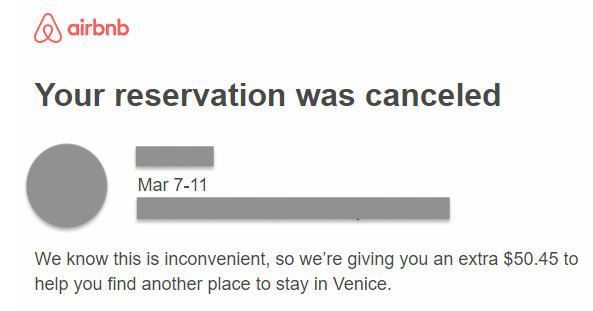

In [1]:
# Import Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import seaborn as sns
%matplotlib inline

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import os
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

In [4]:
H1 = pd.read_csv('Hotel H1.csv')
H2 = pd.read_csv('Hotel H2.csv')
H1['hotel_type'] = 'H1'
H2['hotel_type'] = 'H2'
H1['type'] = 1
H2['type'] = 2
full_data= pd.concat([H1, H2])

In [5]:
# Import Dataset
# full_data= pd.read_csv('/content/HotelDataCombined1330.csv')
# file_path = "/content/hotelbooking.csv"
# full_data = pd.read_csv(file_path,engine='python') # removed this seperatior command etc

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 79329
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateYear              119390 non-null  int64  
 3   ArrivalDateMonth             119390 non-null  object 
 4   ArrivalDateWeekNumber        119390 non-null  int64  
 5   ArrivalDateDayOfMonth        119390 non-null  int64  
 6   StaysInWeekendNights         119390 non-null  int64  
 7   StaysInWeekNights            119390 non-null  int64  
 8   Adults                       119390 non-null  int64  
 9   Children                     119386 non-null  float64
 10  Babies                       119390 non-null  int64  
 11  Meal                         119390 non-null  object 
 12  Country                      118902 non-null  object 
 13  

In [7]:
# check for missing values
full_data.isnull().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         4
Babies                           0
Meal                             0
Country                        488
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

**There is  488 missing value in country**

In [8]:
full_data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel_type,type
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,H1,1
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,H1,1
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,1
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,1
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1,1


In [9]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["Meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# I'm dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["Adults"]
                   + full_data_cln["Children"]
                   + full_data_cln["Babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

### Exploratory Data Analysis (EDA) 
We apply EDA to understand the target variable and its relationship with the other independent variables. We come up with a list of questions:

How Many Booking Were Cancelled? 

What is the booking ratio between Resort Hotel and City Hotel? 

Which is the busiest month for hotels? 

From which country most guests come? 

How Long People Stay in the hotel? 

Which was the most booked accommodation type (Single, Couple, Family)?

What are the Top 10 Countries of Origin of Hotel visitors (Guests)

Which Month is the Most Occupied with Bookings at the Hotel?

Which Month Has Highest Number of Cancellations By Hotel Type?

How many Bookings were Cancelled by Hotel Type?

Total Number of Bookings by Market Segment

Relationship between Special Requests and Cancellations

In [10]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = full_data_cln.loc[(full_data_cln["hotel_type"] == 1) & (full_data_cln["IsCanceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel_type"] == 2) & (full_data_cln["IsCanceled"] == 0)]

**How Many Booking Were Cancelled?+How many Bookings were Cancelled at the Hotel?+How many Bookings were Cancelled by Hotel Type?**

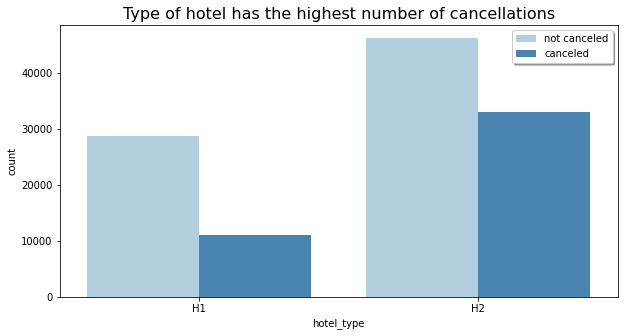

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(data=full_data_cln, x = 'hotel_type',hue='IsCanceled',palette='Blues')
plt.title("Type of hotel has the highest number of cancellations",fontsize=16)
plt.legend(['not canceled','canceled'],shadow = True, loc = 0)
plt.show()

In [12]:
# absolute cancelations:
total_cancelations = full_data_cln["IsCanceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel_type"] == 1]["IsCanceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel_type"] == 2]["IsCanceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel_type"] == 1].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel_type"] == 2].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"H1 bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"H2 bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,052 (37 %)
H1 bookings canceled: 0 (nan %)
H2 bookings canceled: 0 (nan %)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in long_scalars



What is the booking ratio between H1 And H2?




In [13]:
# Now we compare the cancel rate of the city hotel and the resort hotel
can_rate = full_data_cln.groupby(["hotel_type","IsCanceled"]).size().reset_index(name='rate')
summe = can_rate.groupby("hotel_type")['rate'].transform("sum")
can_rate['rate'] = can_rate['rate'].div(summe)
can_rate

,hotel_type,IsCanceled,rate
0,H1,0,0.721966
1,H1,1,0.278034
2,H2,0,0.583525
3,H2,1,0.416475


Which is the busiest month for hotels?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



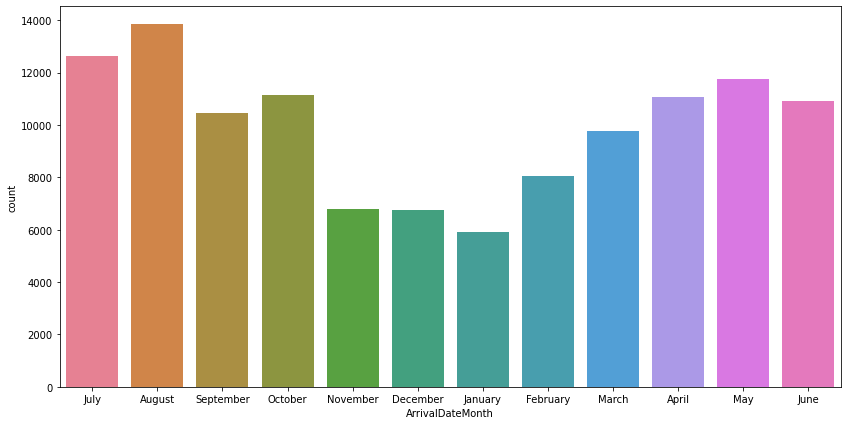

In [14]:
plt.figure(figsize=(14,7))
sns.countplot(full_data_cln['ArrivalDateMonth'], palette='husl')
plt.show()

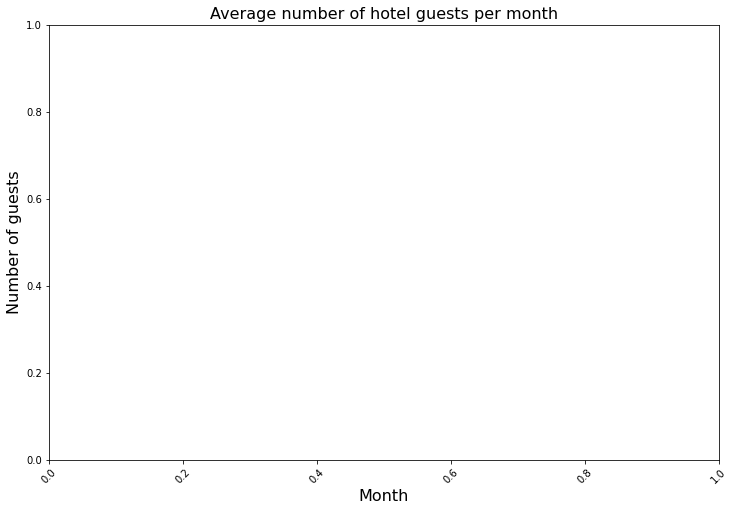

In [15]:
# Create a DateFrame with the relevant data:
H1_guests_monthly = rh.groupby("ArrivalDateMonth")["hotel_type"].count()
H2_guests_monthly = ch.groupby("ArrivalDateMonth")["hotel_type"].count()

H1_guest_data = pd.DataFrame({"Month": list(H1_guests_monthly.index),
                    "hotel_type": 1, 
                    "guests": list(H1_guests_monthly.values)})

H2_guest_data = pd.DataFrame({"Month": list(H2_guests_monthly.index),
                    "hotel_type": 2, 
                    "guests": list(H2_guests_monthly.values)})
full_guest_data = pd.concat([H1_guest_data,H2_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["Month"] = pd.Categorical(full_guest_data["Month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["Month"] == "July") | (full_guest_data["Month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["Month"] == "July") | (full_guest_data["Month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "Month", y="guests", data=full_guest_data)
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

**From which country most guests come?**

In [16]:
# get number of acutal guests by country
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["IsCanceled"] == 0]["Country"].value_counts())
#country_data.index.name = "country"
country_data.rename(columns={"Country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["Country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="Country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

Which was the most booked accommodation type (Single, Couple, Family)?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



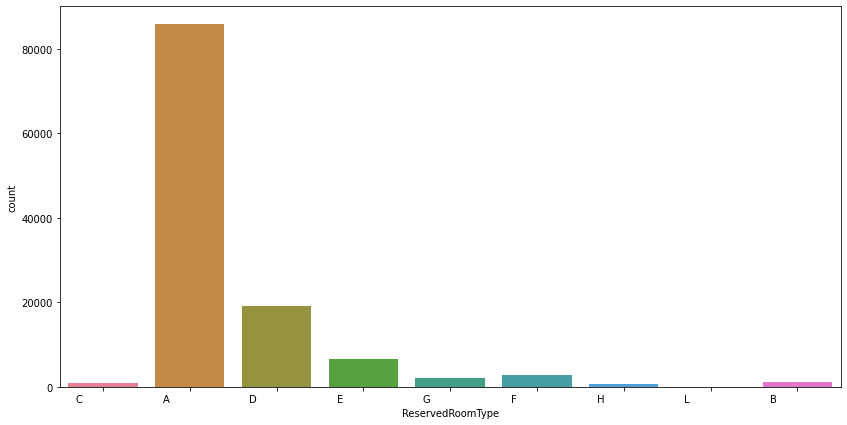

In [17]:
plt.figure(figsize=(14,7))
sns.countplot(full_data_cln['ReservedRoomType'], palette='husl')
plt.show()

What are the Top 10 Countries of Origin of Hotel visitors (Guests)

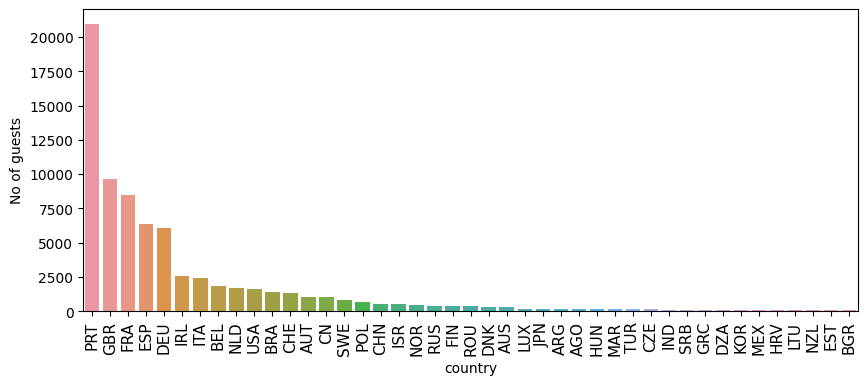

In [18]:
fig = plt.figure(figsize=(10,4), dpi=100)


country_wise_guests = full_data_cln[(full_data_cln['IsCanceled'] == 0)]['Country'].value_counts().reset_index()
country_wise_guests.columns = ['country', 'No of guests']

country_wise_guests = country_wise_guests[country_wise_guests['No of guests'] > 60]

sns.barplot(data=country_wise_guests, x = 'country', y = 'No of guests')
plt.xticks(rotation=90,fontsize=11);

Which Month Has Highest Number of Cancellations By Hotel Type?

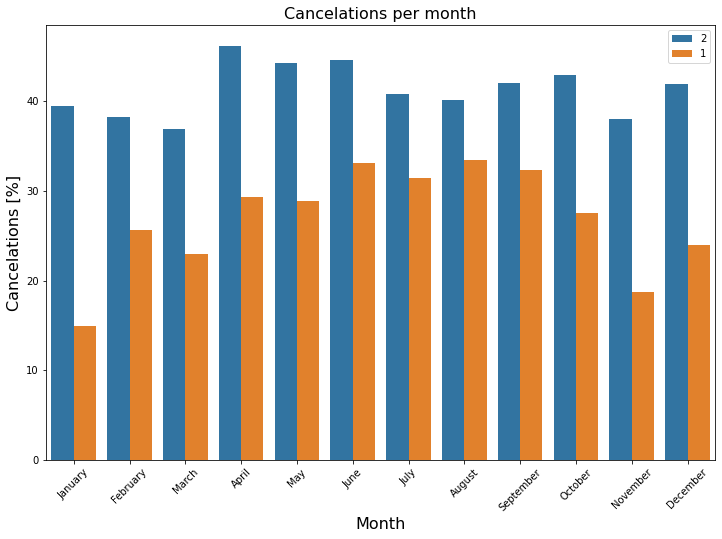

In [19]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["type"] == 1)].groupby("ArrivalDateMonth")["type"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["type"] == 1)].groupby("ArrivalDateMonth")["IsCanceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["type"] == 2)].groupby("ArrivalDateMonth")["type"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["type"] == 2)].groupby("ArrivalDateMonth")["IsCanceled"].sum()

res_cancel_data = pd.DataFrame({"type": 1,
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"type": 2,
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="type",
            hue_order = [2, 1], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

Total Number of Bookings by Market Segment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



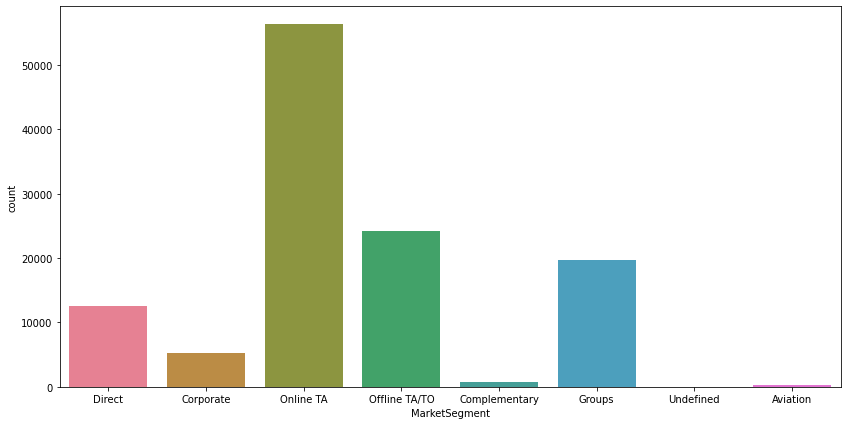

In [20]:
plt.figure(figsize=(14,7))
sns.countplot(full_data_cln['MarketSegment'], palette='husl')
plt.show()

In [21]:
# total bookings per market segment (incl. canceled)
segments=full_data_cln["MarketSegment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

Arrival Date Year vs Lead Time By Booking Cancellation Status

In [22]:
city_hotel=full_data_cln.groupby(['ArrivalDateMonth'])['IsCanceled'].mean().reset_index()
city_hotel

,ArrivalDateMonth,IsCanceled
0,April,0.407076
1,August,0.377683
2,December,0.349082
3,February,0.333955
4,January,0.303810
5,July,0.373901
6,June,0.414286
7,March,0.321344
8,May,0.396632
9,November,0.311439


Relationship between Special Requests and Cancellations


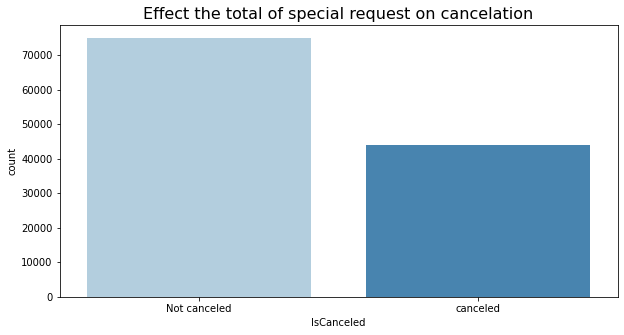

In [23]:
plt.figure(figsize=(10, 5))
plt.title("Effect the total of special request on cancelation",fontsize=16)
total_of_special=sns.countplot(data=full_data_cln,x='IsCanceled', palette='Blues')
total_of_special.set_xticklabels(['Not canceled','canceled']);

### Data Visualization

To identify trends and other insights form the dataset

### Clustering to Segment Customers

Use clustering to segment customers and then create new categorical variables corresponding to these segments and check how customer segments influence booking cancellation.

In [24]:
full_data_cln.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119030 entries, 0 to 79329
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119030 non-null  int64  
 1   LeadTime                     119030 non-null  int64  
 2   ArrivalDateYear              119030 non-null  int64  
 3   ArrivalDateMonth             119030 non-null  object 
 4   ArrivalDateWeekNumber        119030 non-null  int64  
 5   ArrivalDateDayOfMonth        119030 non-null  int64  
 6   StaysInWeekendNights         119030 non-null  int64  
 7   StaysInWeekNights            119030 non-null  int64  
 8   Adults                       119030 non-null  int64  
 9   Children                     119026 non-null  float64
 10  Babies                       119030 non-null  int64  
 11  Meal                         119030 non-null  object 
 12  Country                      118555 non-null  object 
 13  

In [25]:
# weather["Temp"] = weather.Temp.astype(float)
full_data_cln['ADR'] = full_data_cln['ADR'].astype(float)

In [63]:
df_mask=full_data_cln['ADR']<=4000
full_data_cln = full_data_cln[df_mask]

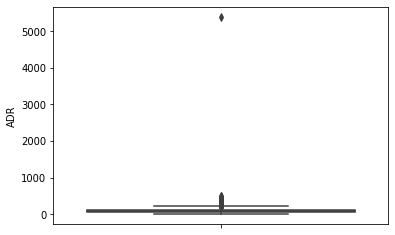

In [26]:
import seaborn as sns
sns.boxplot(y='ADR', data=full_data_cln)

In [27]:
# Log variables:
full_data['ADR_log'] = np.log(full_data['ADR'])
full_data['LeadTime_log'] = np.log(full_data['LeadTime']+2)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in log



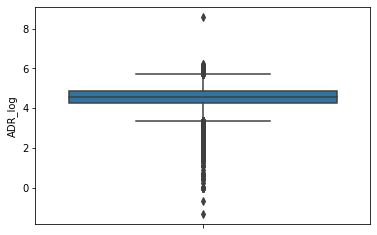

In [29]:
sns.boxplot(y='ADR_log', data=full_data)

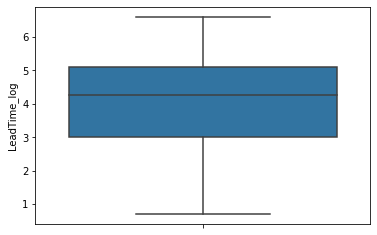

In [30]:
sns.boxplot(y='LeadTime_log', data=full_data)

In [78]:
# Log variables:
# full_data_cln['b'] = df['b'] + 10
full_data_cln['ADR_log'] = np.log(full_data_cln['ADR'])
# add +1 to lead time
full_data['LeadTime_log'] = full_data['LeadTime']+10
full_data['LeadTime_log']

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in log



0        352
1        747
2         17
3         23
4         24
        ... 
79325     33
79326    112
79327     44
79328    119
79329    215
Name: LeadTime_log, Length: 119390, dtype: int64

In [79]:
# Scaling
from sklearn.preprocessing import scale
logleadtime = full_data['LeadTime_log']
logadr = full_data['ADR_log']
leadtime = full_data['LeadTime']
adr = full_data['ADR']
x1 = np.column_stack((adr, leadtime))
x1
X = scale(x1)
X

array([[-2.0150382 ,  2.22705112],
       [-2.0150382 ,  5.9233847 ],
       [-0.53093528, -0.90781407],
       ...,
       [ 1.10573343, -0.65515329],
       [ 0.05083307,  0.0466822 ],
       [ 0.97691329,  0.94503163]])

Draw elbow graph

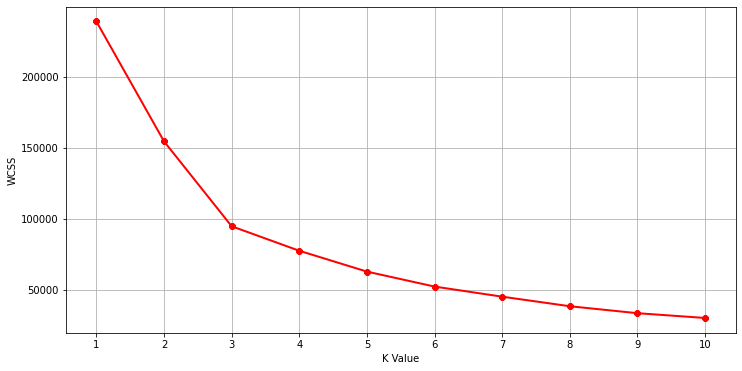

In [80]:
# Draw elbow graph

from sklearn.cluster import KMeans

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [81]:
from sklearn.cluster import KMeans
# km = KMeans(n_clusters = 5, n_jobs = None, random_state = None)
km = KMeans(n_clusters = 3, random_state = None)
km.fit(X)

KMeans(n_clusters=3)

In [82]:
marketcat=full_data_cln.MarketSegment.astype("category").cat.codes
marketcat=pd.Series(marketcat)
y1 = marketcat
Y=np.array(y1)

Text(0.5, 1.0, 'Labels: Actual')

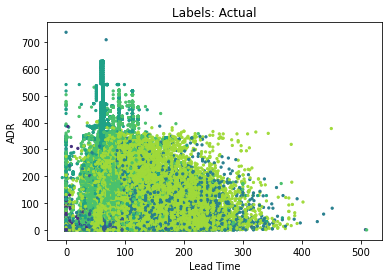

In [83]:
plt.scatter(x=full_data_cln['ADR'],y=full_data_cln['LeadTime'], c=Y, s=5)
#plt.scatter(x=X[:,0],y=X[:,1], c=color_theme[Y], s=50)
plt.xlabel("Lead Time")
plt.ylabel("ADR")
plt.title('Labels: Actual')

In [84]:
km.labels_.astype(float)

array([2., 2., 1., ..., 0., 1., 0.])

In [85]:
centers = km.cluster_centers_
print(centers)

[[ 1.2430698  -0.32248381]
 [-0.49177461 -0.51827778]
 [-0.26150465  1.4799692 ]]


In [86]:
color_theme = np.array(['firebrick', 'dodgerblue', 'forestgreen', 'goldenrod', 'rebeccapurple'])

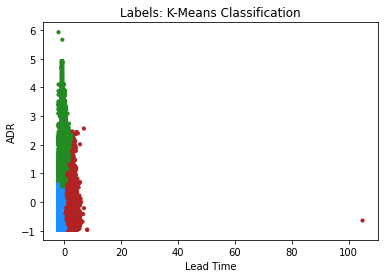

In [87]:
plt.scatter(x=X[:,0],y=X[:,1], c=color_theme[km.labels_], s=10)
plt.xlabel("Lead Time")
plt.ylabel("ADR")
plt.title('Labels: K-Means Classification')
plt.show()

In [88]:
km.labels_

array([2, 2, 1, ..., 0, 1, 0], dtype=int32)

In [89]:
# clusters = km.fit_predict(data.iloc[:,1:])
clusters = km.predict(X)

In [90]:
full_data["cluster_label"] = clusters
full_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel_type,type,ADR_log,LeadTime_log,cluster_label,ArrivalDate,ReservationStatusDateYear,ReservationStatusDateMonth,ReservationStatusDateDay
0,0,342,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1,1,-inf,352,2,2015-07-01,2015,7,1
1,0,737,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1,1,-inf,747,2,2015-07-01,2015,7,1
2,0,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1,1,4.317488,17,1,2015-07-01,2015,7,2
3,0,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1,1,4.317488,23,1,2015-07-01,2015,7,2
4,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,H1,1,4.584967,24,1,2015-07-01,2015,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,8,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,H2,2,4.565805,33,1,2017-08-30,2017,9,6
79326,0,102,2017,8,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,H2,2,5.418010,112,0,2017-08-31,2017,9,7
79327,0,34,2017,8,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,H2,2,5.060758,44,0,2017-08-31,2017,9,7
79328,0,109,2017,8,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,H2,2,4.648230,119,1,2017-08-31,2017,9,7


### Prediction of Booking Cancellations 

Predict if a booking would be cancelled (and identify which factors are important predictors than the others).

In [91]:
import datetime


from month(january) to month number(1)

In [93]:
full_data.ArrivalDateMonth

0        7
1        7
2        7
3        7
4        7
        ..
79325    8
79326    8
79327    8
79328    8
79329    8
Name: ArrivalDateMonth, Length: 119390, dtype: int64

In [ ]:
H_full_copy = full_data.ArrivalDateMonth.apply(lambda x: datetime.datetime.strptime(x, "%B"))
H_full_copy = H_full_copy.apply(lambda x: x.month)
full_data['ArrivalDateMonth'] = H_full_copy

creating Arrival date by joining "ArrivalDateYear", "ArrivalDateMonth", "ArrivalDateDayOfMonth"

In [94]:
df2 = full_data[["ArrivalDateYear", "ArrivalDateMonth", "ArrivalDateDayOfMonth"]].copy()
df2.columns = ["year", "month", "day"]
pd.to_datetime(df2)
full_data['ArrivalDate'] =  pd.to_datetime(df2[["year", "month", "day"]], format = '%Y-%m-%d')
full_data['ArrivalDate'].head()

0   2015-07-01
1   2015-07-01
2   2015-07-01
3   2015-07-01
4   2015-07-01
Name: ArrivalDate, dtype: datetime64[ns]

converting ReservationStatusDate to date

In [95]:
full_data['ReservationStatusDate']= pd.to_datetime(full_data['ReservationStatusDate'])

In [96]:
full_data.dtypes

IsCanceled                              int64
LeadTime                                int64
ArrivalDateYear                         int64
ArrivalDateMonth                        int64
ArrivalDateWeekNumber                   int64
ArrivalDateDayOfMonth                   int64
StaysInWeekendNights                    int64
StaysInWeekNights                       int64
Adults                                  int64
Children                              float64
Babies                                  int64
Meal                                   object
Country                                object
MarketSegment                          object
DistributionChannel                    object
IsRepeatedGuest                         int64
PreviousCancellations                   int64
PreviousBookingsNotCanceled             int64
ReservedRoomType                       object
AssignedRoomType                       object
BookingChanges                          int64
DepositType                       

In [97]:
H_full = full_data

unpack ReservationStatusDate in order to have yy,mm and dd

In [98]:
H_full['ReservationStatusDateYear'] = pd.to_datetime(H_full['ReservationStatusDate']).dt.year
H_full['ReservationStatusDateMonth'] = pd.to_datetime(H_full['ReservationStatusDate']).dt.month
H_full['ReservationStatusDateDay'] = pd.to_datetime(H_full['ReservationStatusDate']).dt.day

In [99]:
features_num = [
    "DaysInWaitingList","BookingChanges","LeadTime", "ArrivalDateWeekNumber",
    "ArrivalDateDayOfMonth", "StaysInWeekendNights",
    "StaysInWeekNights", "Adults", "Children", "Babies",
    "IsRepeatedGuest", "PreviousCancellations",
    "PreviousBookingsNotCanceled", "RequiredCarParkingSpaces",
    "TotalOfSpecialRequests", "ADR","ReservationStatusDateDay"
]
features_cat = [
    "hotel_type","Country","cluster_label", "ArrivalDateMonth","Company","Agent", "Meal", "CustomerType","ArrivalDateMonth",
    "MarketSegment","ArrivalDateYear","DepositType","ReservationStatusDateMonth", "DistributionChannel",
    "ReservedRoomType","AssignedRoomType","ReservationStatus","ReservationStatusDateYear"
]


In [100]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [101]:
X = H_full.drop('IsCanceled', axis=1)
y = H_full['IsCanceled']

In [102]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [103]:
X_train.shape[1]

933

Neuron architecture

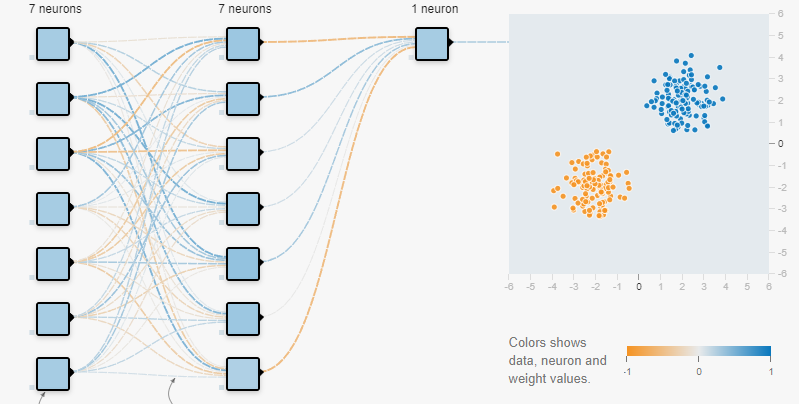

In [104]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=7, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.2),
    layers.Dense(units=7, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid'),
])

In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 7)                 6538      
                                                                 
 dropout_2 (Dropout)         (None, 7)                 0         
                                                                 
 dense_4 (Dense)             (None, 7)                 56        
                                                                 
 dropout_3 (Dropout)         (None, 7)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 8         
                                                                 
Total params: 6,602
Trainable params: 6,602
Non-trainable params: 0
_________________________________________________________________


Stochastic gradient descent

In [106]:
from tensorflow.keras.optimizers import SGD
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [107]:
X_train = X_train.toarray()
X_valid = X_valid.toarray()

Epoch 1/30
175/175 [==============================] - 2s 7ms/step - loss: 0.0975 - binary_accuracy: 0.9535 - val_loss: 0.0011 - val_binary_accuracy: 0.9996
Epoch 2/30
175/175 [==============================] - 1s 7ms/step - loss: 0.0227 - binary_accuracy: 0.9919 - val_loss: 2.0671e-04 - val_binary_accuracy: 0.9999
Epoch 3/30
175/175 [==============================] - 1s 7ms/step - loss: 0.0188 - binary_accuracy: 0.9932 - val_loss: 1.3747e-06 - val_binary_accuracy: 1.0000
Epoch 4/30
175/175 [==============================] - 1s 7ms/step - loss: 0.0220 - binary_accuracy: 0.9915 - val_loss: 8.5106e-04 - val_binary_accuracy: 0.9995
Epoch 5/30
175/175 [==============================] - 1s 7ms/step - loss: 0.0184 - binary_accuracy: 0.9923 - val_loss: 4.7251e-05 - val_binary_accuracy: 1.0000
Epoch 6/30
175/175 [==============================] - 1s 7ms/step - loss: 0.0183 - binary_accuracy: 0.9920 - val_loss: 5.5153e-06 - val_binary_accuracy: 1.0000
Epoch 7/30
175/175 [========================

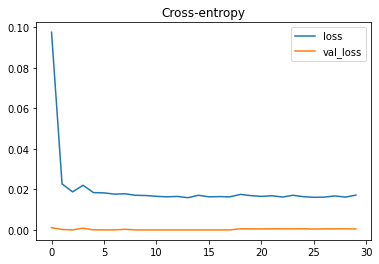

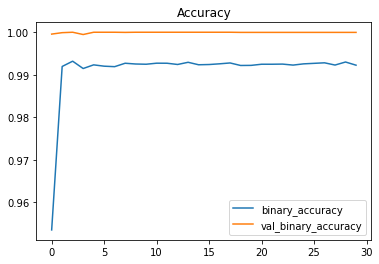

In [108]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=30
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

with callbacks

Epoch 1/30
175/175 [==============================] - 1s 8ms/step - loss: 0.0164 - binary_accuracy: 0.9924 - val_loss: 5.6773e-04 - val_binary_accuracy: 1.0000
Epoch 2/30
175/175 [==============================] - 1s 7ms/step - loss: 0.0169 - binary_accuracy: 0.9923 - val_loss: 4.9793e-04 - val_binary_accuracy: 1.0000
Epoch 3/30
175/175 [==============================] - 1s 6ms/step - loss: 0.0158 - binary_accuracy: 0.9929 - val_loss: 5.3993e-04 - val_binary_accuracy: 1.0000
Epoch 4/30
175/175 [==============================] - 1s 6ms/step - loss: 0.0172 - binary_accuracy: 0.9921 - val_loss: 6.0628e-04 - val_binary_accuracy: 1.0000
Epoch 5/30
175/175 [==============================] - 1s 6ms/step - loss: 0.0170 - binary_accuracy: 0.9925 - val_loss: 5.3637e-04 - val_binary_accuracy: 1.0000
Epoch 6/30
175/175 [==============================] - 1s 6ms/step - loss: 0.0171 - binary_accuracy: 0.9921 - val_loss: 5.1959e-04 - val_binary_accuracy: 1.0000
Epoch 7/30
175/175 [====================

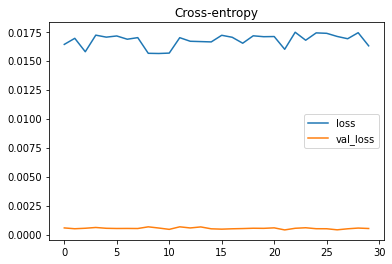

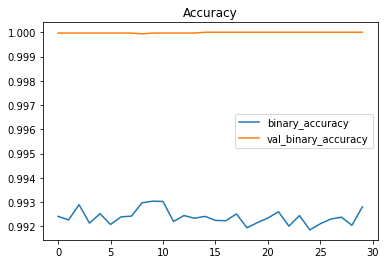

In [109]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=30,
    # callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [110]:
 from sklearn.metrics import roc_curve, roc_auc_score
 y_score1 = model.predict(X_valid)
 false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_valid, y_score1)
 print('roc_auc_score for DNN: ', roc_auc_score(y_valid, y_score1))

roc_auc_score for DNN:  1.0


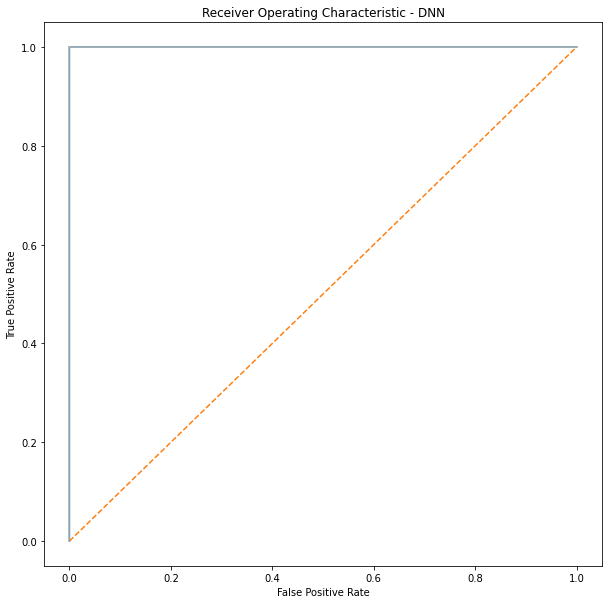

In [111]:
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DNN')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()